# TL Performance 7T

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
theme_set(theme_minimal())
options(repr.plot.width = 14)

In [3]:
# see compare_predictions
base_performance=c(lv=.814,my=.676)

In [4]:
images_per_epoch = read_tsv("../../analysis/7T/image_subsets.tsv")

Parsed with column specification:
cols(
  file = col_character(),
  Id = col_double(),
  frame = col_double(),
  slice = col_double(),
  v7 = col_logical(),
  v3 = col_logical(),
  v1 = col_logical(),
  r7 = col_logical(),
  r3 = col_logical(),
  r1 = col_logical(),
  esed = col_logical(),
  r_esed = col_logical()
)


In [5]:
images_per_epoch <- images_per_epoch %>%
    mutate(full = TRUE) %>%
    summarise_if(is.logical, sum) %>%
    t %>% data.frame %>%
    rownames_to_column('subset') %>%
    rename(images_per_epoch=2)

# Training log

In [6]:
train_log <- read_csv("../../analysis/7T/train_log_combined.csv", col_types = cols(
  epoch = col_double(),
  train_loss = col_double(),
  valid_loss = col_double(),
  acc_seg = col_double(),
  diceComb = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  time = col_time(format = "%M:%S"),
  model = col_character()
)) %>%
    mutate(
        model = str_replace(model, 'doubleTransferLearn', 'TL2'),
        model = str_replace(model, 'imagenetTransferLearn', 'TL'),
        model = str_replace(model, 'plainLearn', 'R'),
        epoch=epoch+1,
    ) %>%
    separate(model, into=c("model","subset"), sep="_", fill = "right", extra = "merge") %>%
    replace_na(list(subset="full")) %>%
    left_join(images_per_epoch) %>%
    mutate(images=epoch*images_per_epoch)

Joining, by = "subset"


### full training set

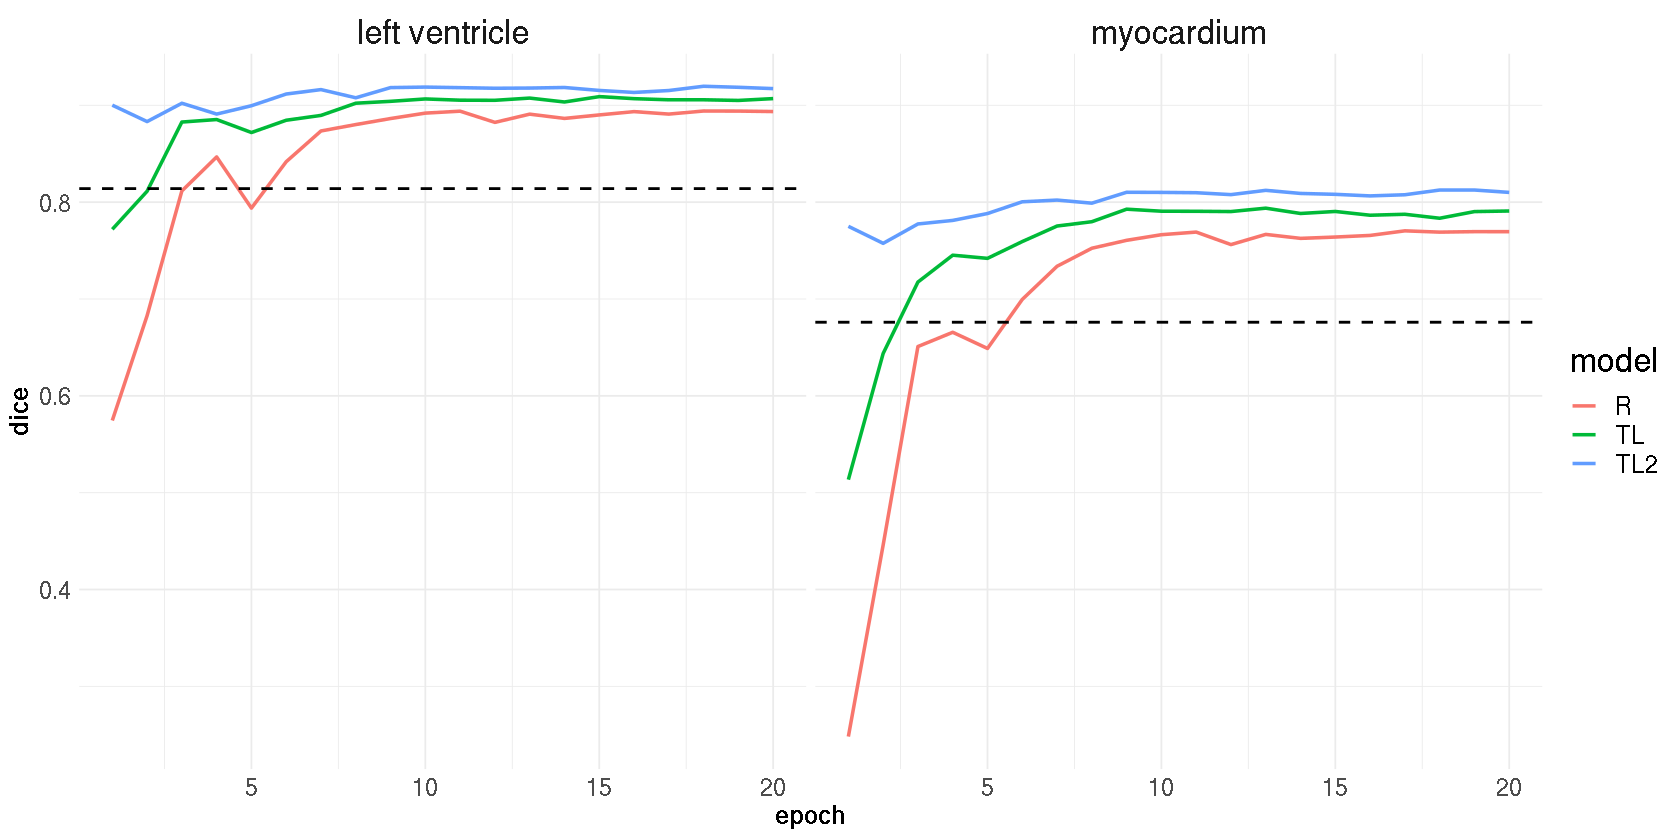

In [7]:
train_log %>%
    filter(subset=="full") %>%
    gather("score","value",2:7) %>%
    filter(str_detect(score,"dice(L|M)")) %>%
    mutate(
        score = str_replace(score, 'diceLV', 'left ventricle'),
        score = str_replace(score, 'diceMY', 'myocardium'),
        dice = value
    ) %>%
    ggplot(aes(x=epoch,y=dice,color=model)) +
        facet_wrap(~score) +
        geom_line(lwd=1) +
        geom_hline(data=tibble(score=c('left ventricle','myocardium'),value=base_performance), aes(yintercept=value), lty=2, lwd=.8) +
        theme(
            axis.text = element_text( size = 14 ),
            axis.title = element_text( size = 16, face = "bold" ),
            strip.text = element_text(size = 20),
            legend.title = element_text(size = 20),
            legend.text = element_text(size = 16)
        )

Look at loss for saturation or overfitting

Warning message:
“Removed 7 row(s) containing missing values (geom_path).”

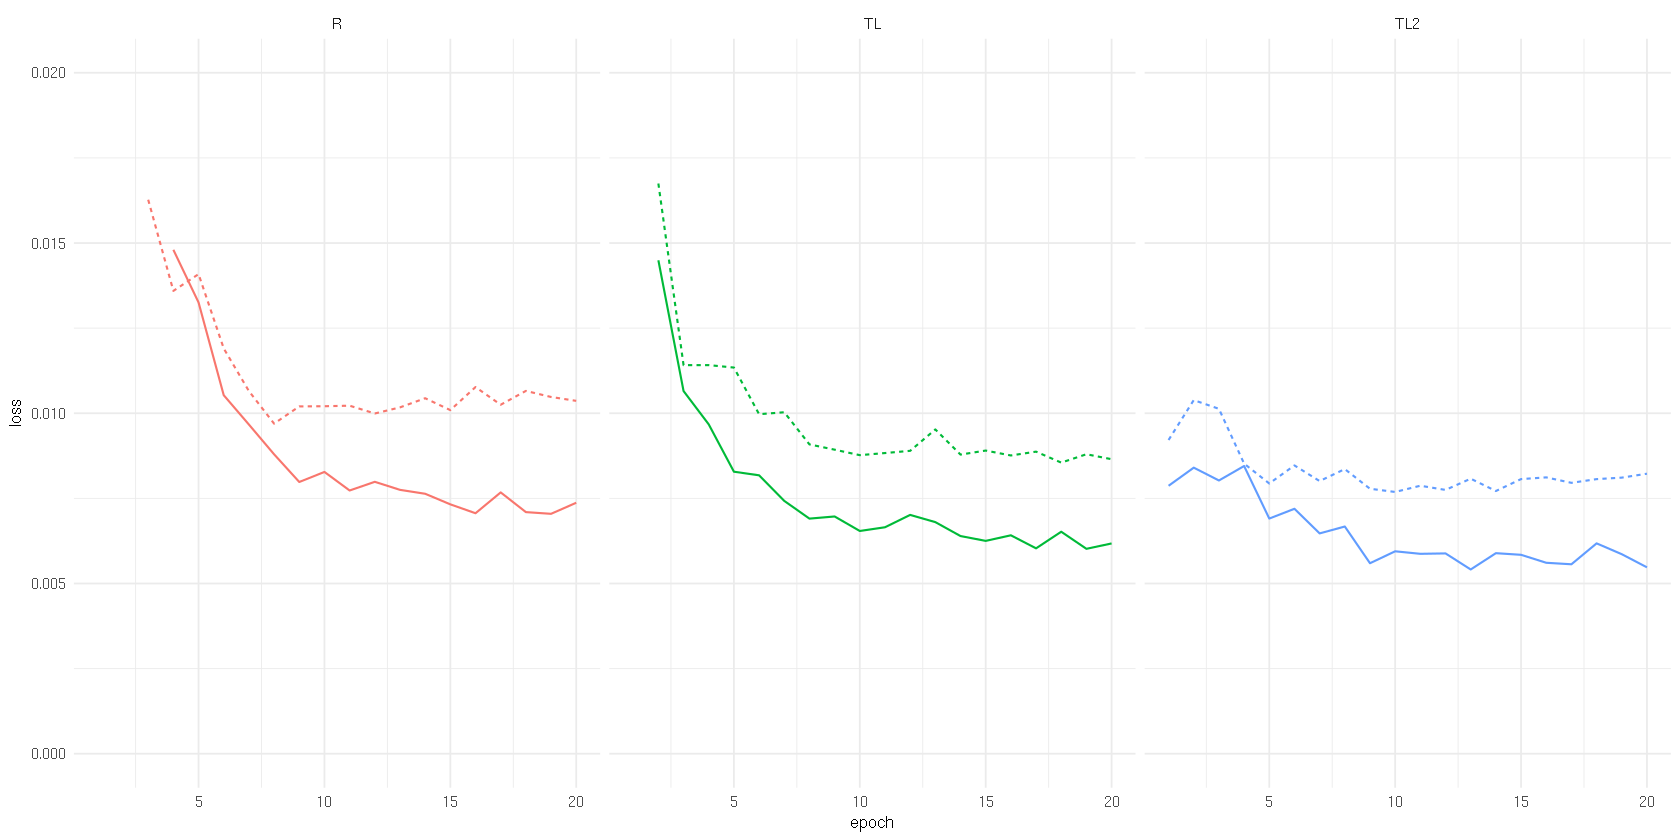

In [8]:
train_log %>% filter(subset=="full") %>% gather("score","loss",2:7) %>% filter(str_detect(score,"loss")) %>% ggplot(aes(x=epoch,y=loss,color=model)) + geom_line(aes(lty=score),lwd=.6) + ylim(0,.02) + facet_wrap(~model) + theme(legend.position = "none")

### subsets

Warning message:
“Removed 224 row(s) containing missing values (geom_path).”

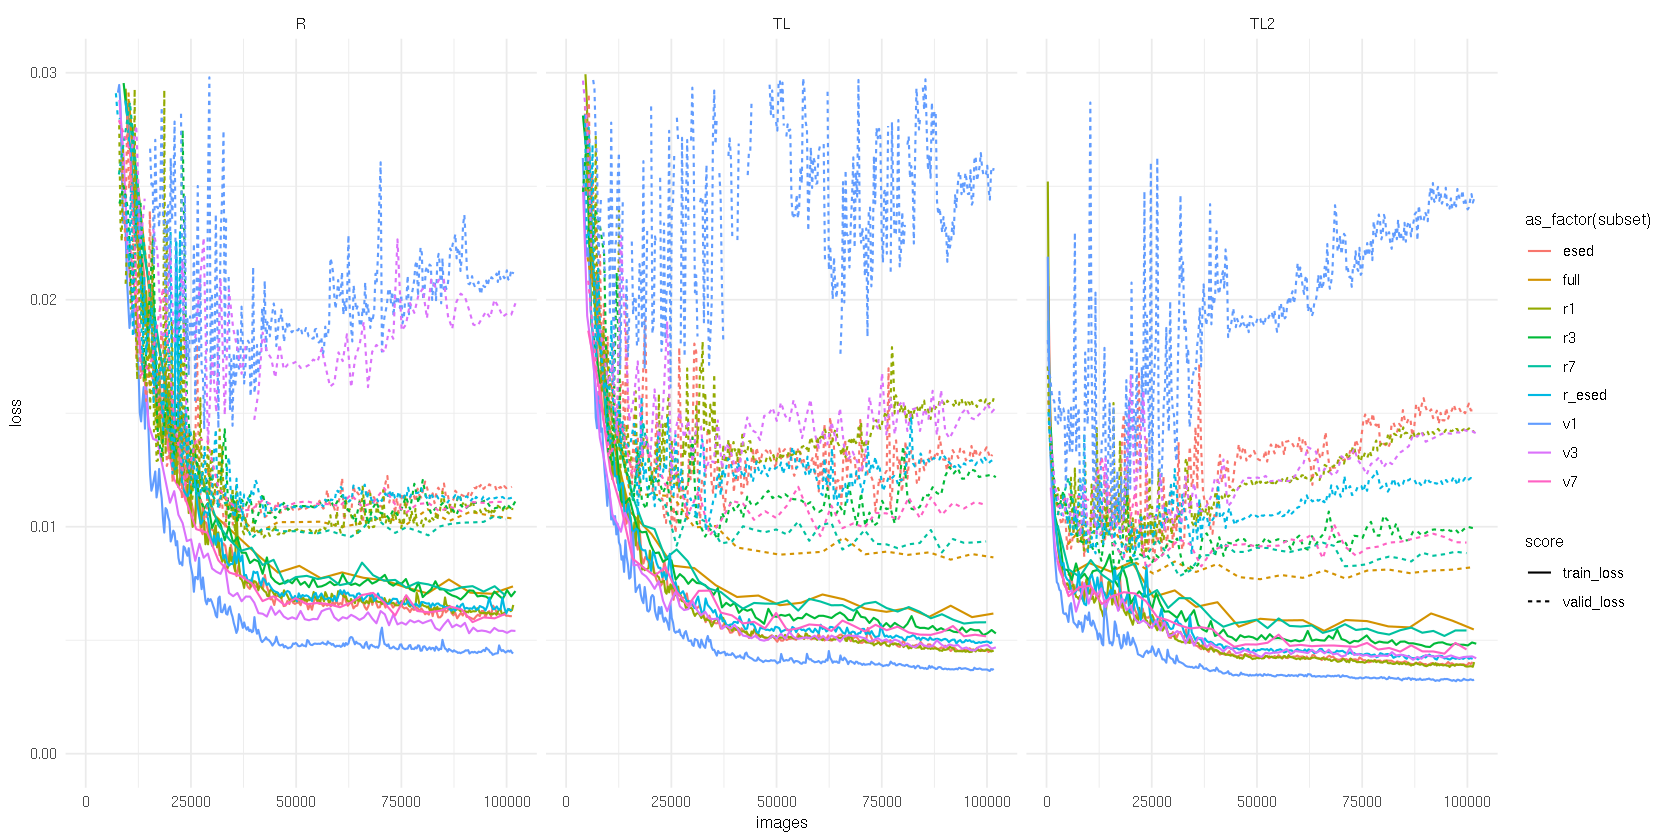

In [9]:
train_log %>% 
    gather("score","loss",2:7) %>%
    filter(str_detect(score,"loss")) %>%
    ggplot(aes(x=images,y=loss,color=as_factor(subset))) +
        geom_line(aes(lty=score),lwd=.6) +
        ylim(0,.03) +
        facet_wrap(~model) 

For small subsets there are signs of overfitting

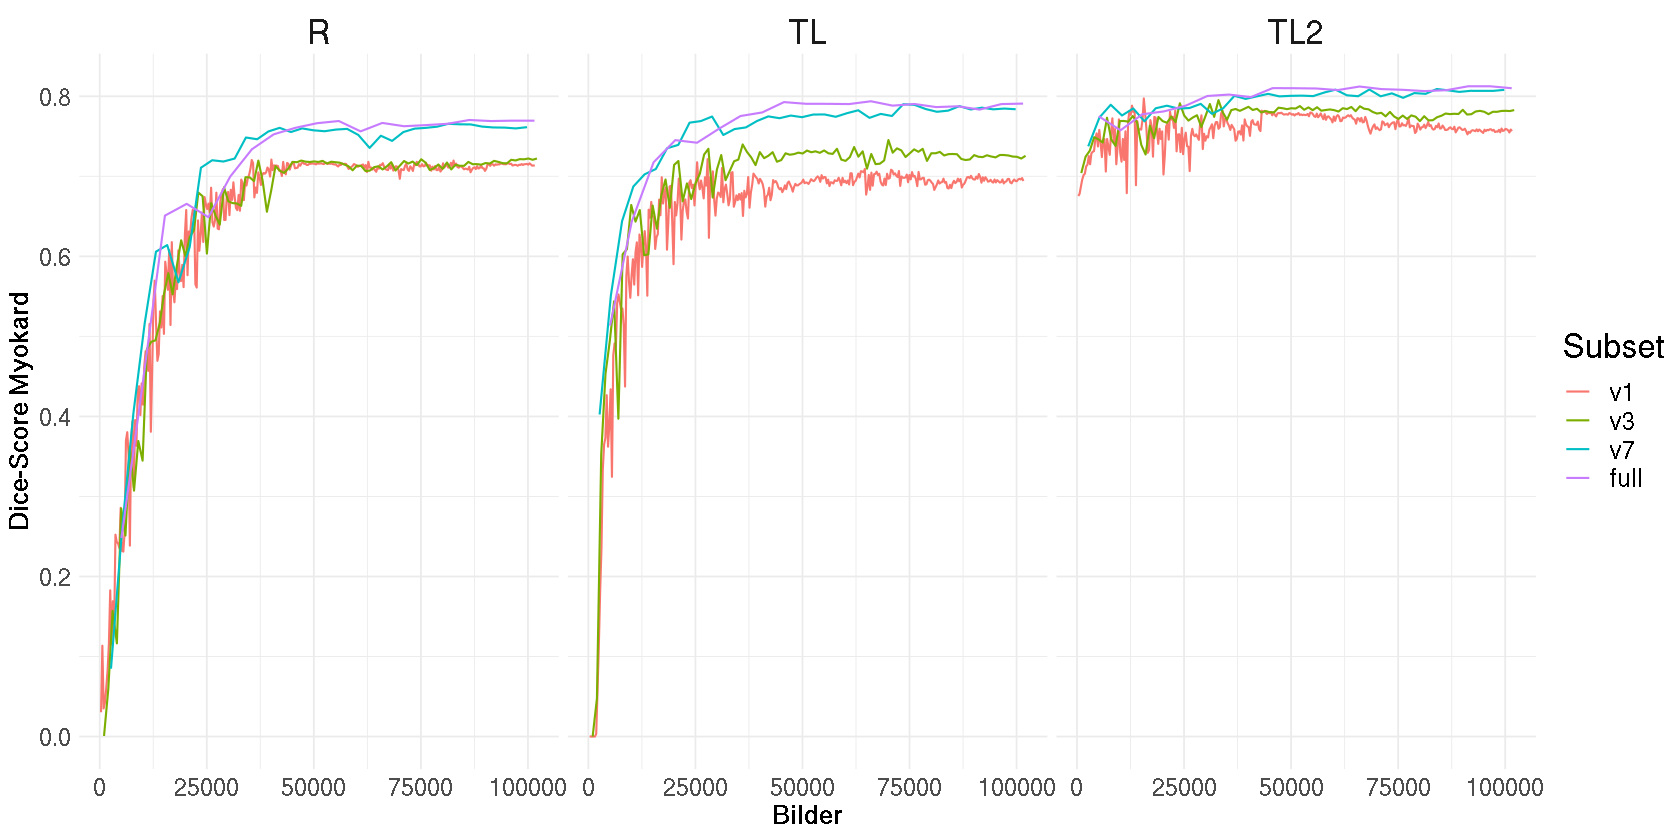

In [10]:
train_log %>% filter(subset=="full" | str_detect(subset, "v")) %>%
    mutate(Subset=fct_relevel(subset,"full",after = 3)) %>%
    gather("score","value",2:7) %>% filter(str_detect(score,"diceM")) %>%
    ggplot(aes(x=images,y=value,color=Subset)) + geom_line(lwd=.6) + facet_wrap(~model) +
    xlab("Bilder") + ylab("Dice-Score Myokard") +
    theme(
        axis.text = element_text( size = 14 ),
        axis.title = element_text( size = 16, face = "bold" ),
        strip.text = element_text(size = 20),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 16)
    ) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


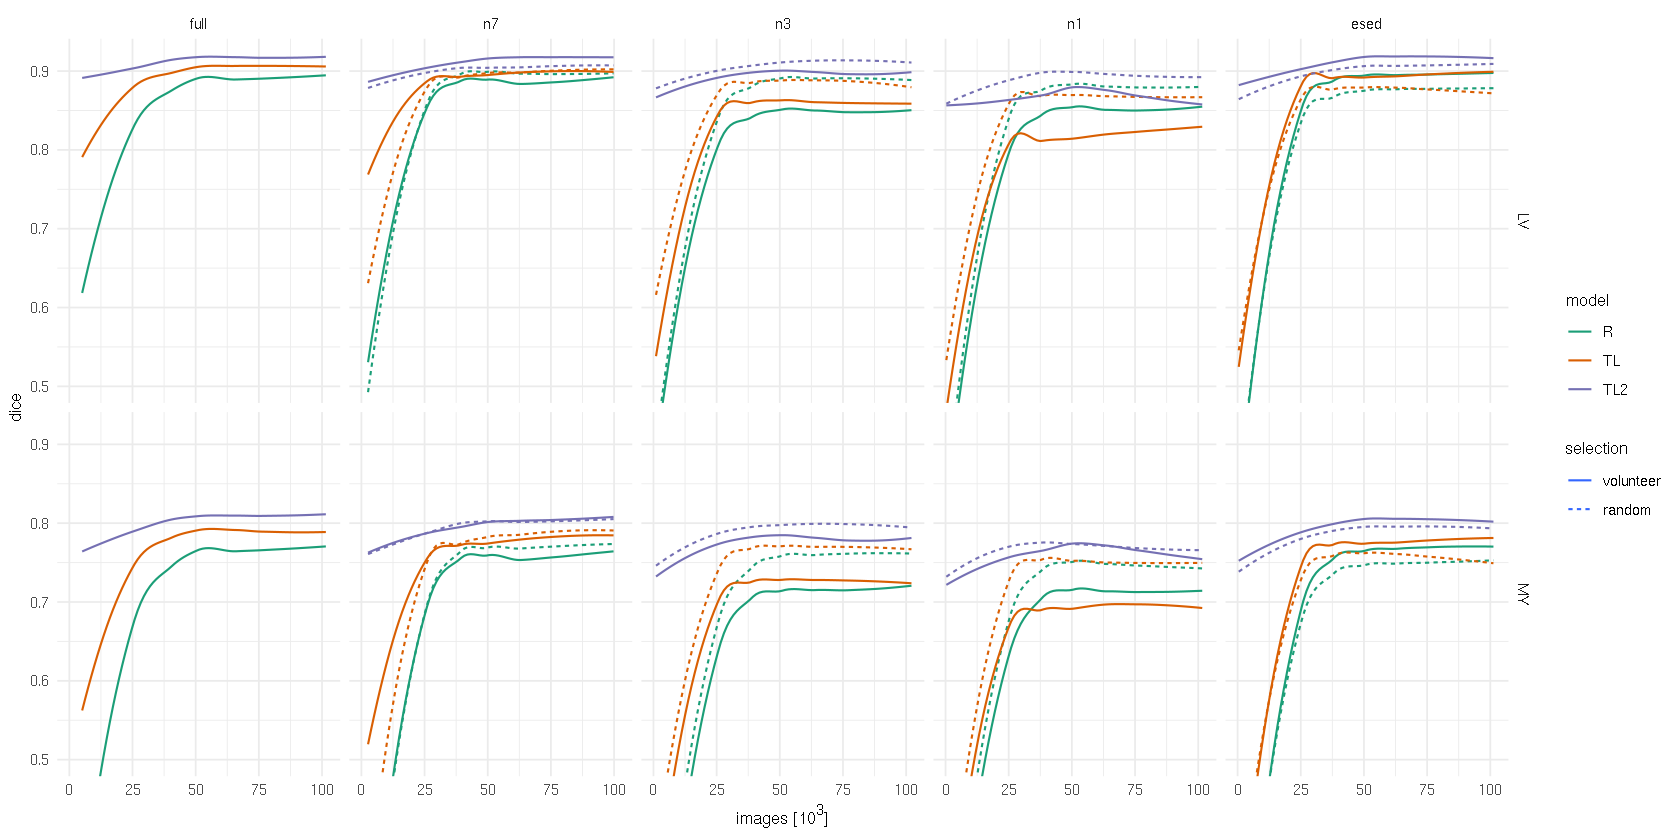

In [11]:
smooth_plot <- train_log %>%
    gather("score","dice",2:7) %>%
    mutate(
        selection = if_else(str_detect(subset,"r"),"random","volunteer"),
        selection = fct_relevel(selection,"volunteer"),
        subset = str_replace(subset,"v|r","n"),
        subset = str_replace(subset,"n_",""),
    ) %>%
    filter(str_detect(score,"dice(L|M)")) %>%
    mutate(
        score=str_replace(score,"dice",""),
        subset=fct_reorder(subset,-images_per_epoch),
        subset=fct_relevel(subset, "esed", after = 4),
        images=images/1000
    ) %>%
    ggplot(aes(x=images,y=dice,color=model,lty=selection)) +
        #geom_point(size=.5, alpha=.5) +
        geom_smooth(lwd=.6,se=FALSE) +
        facet_grid(score~as_factor(subset)) +
    scale_color_brewer(palette = "Dark2") +
    coord_cartesian(ylim=c(.5,.92)) +
    xlab(expression(paste("images [10"^3,"]")))
smooth_plot

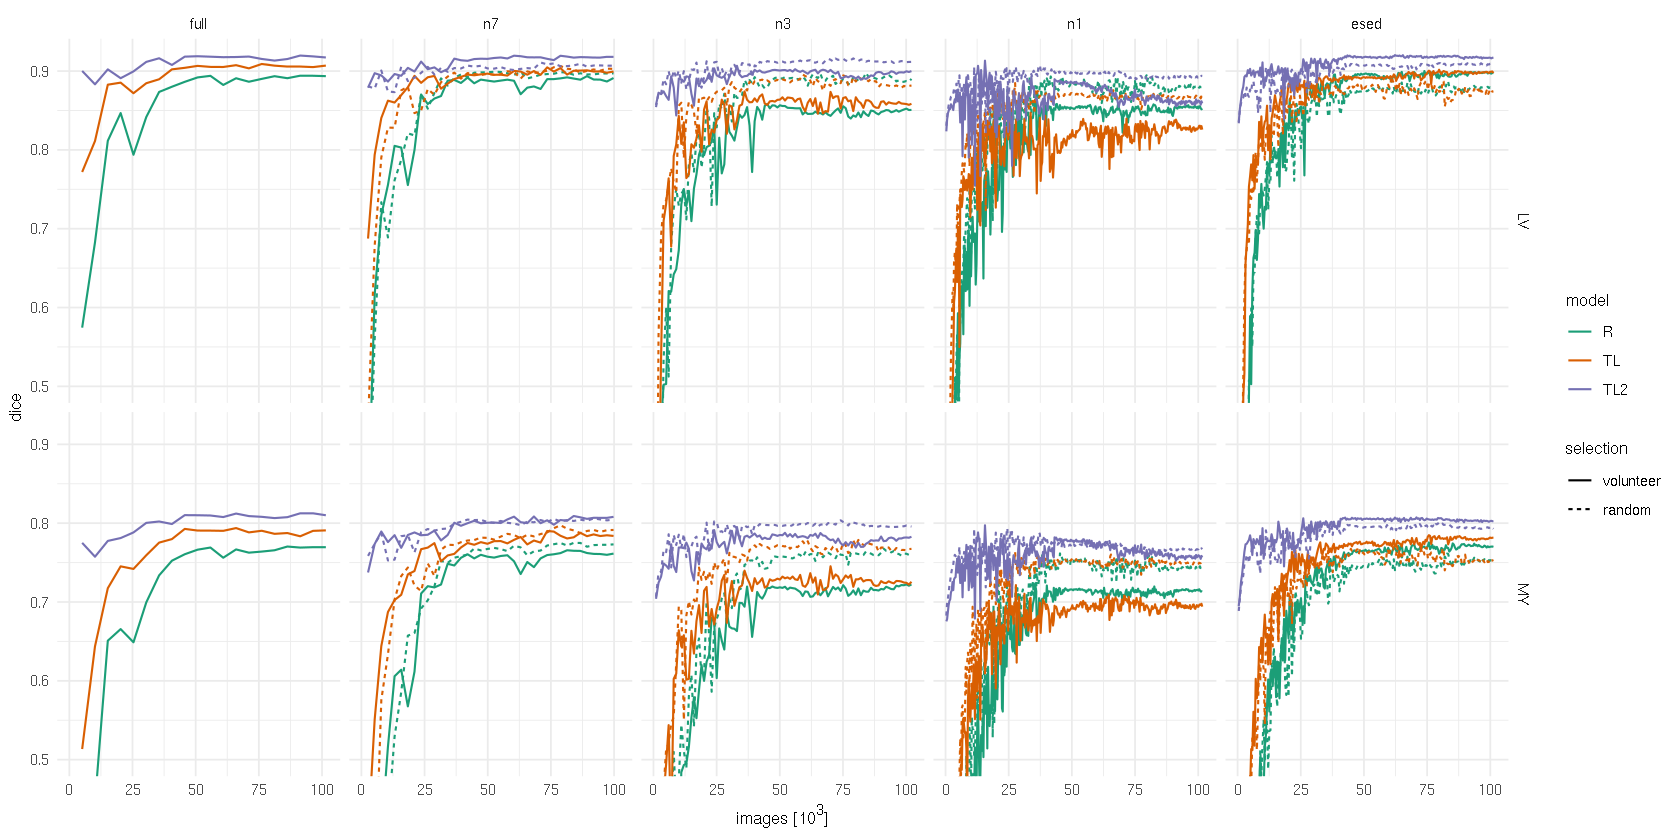

In [12]:
train_log %>%
    gather("score","dice",2:7) %>%
    mutate(
        selection = if_else(str_detect(subset,"r"),"random","volunteer"),
        selection = fct_relevel(selection,"volunteer"),
        subset = str_replace(subset,"v|r","n"),
        subset = str_replace(subset,"n_",""),
    ) %>%
    filter(str_detect(score,"dice(L|M)")) %>%
    mutate(
        score=str_replace(score,"dice",""),
        subset=fct_reorder(subset,-images_per_epoch),
        subset=fct_relevel(subset, "esed", after = 4),
        images=images/1000
    ) %>%
    ggplot(aes(x=images,y=dice,color=model,lty=selection)) +
        #geom_point(size=.5, alpha=.5) +
        geom_line(lwd=.6) +
        facet_grid(score~as_factor(subset)) +
    scale_color_brewer(palette = "Dark2") +
    coord_cartesian(ylim=c(.5,.92)) +
    xlab(expression(paste("images [10"^3,"]")))

### Starting Performance

In [13]:
train_log %>% filter(subset=="full") %>% group_by(model) %>% top_n(1,-epoch) %>% select(model,diceLV,diceMY) %>% ungroup %>% mutate_if(is.numeric, round, 2)

model,diceLV,diceMY
TL2,0.90,0.78
TL,0.77,0.51
R,0.57,0.25


In [14]:
train_log %>% group_by(model,subset) %>% top_n(1,-epoch) %>% select(model,subset,diceLV,diceMY) %>% ungroup %>% mutate_if(is.numeric, round, 2)

model,subset,diceLV,diceMY
TL2,esed,0.84,0.69
TL2,full,0.90,0.78
TL2,r1,0.83,0.68
TL2,r3,0.85,0.71
TL2,r7,0.88,0.76
TL2,r_esed,0.83,0.69
TL2,v1,0.82,0.68
TL2,v3,0.86,0.70
TL2,v7,0.88,0.74
TL,esed,0.07,0.00


### Smooth Peak Performance

Extract smoothed maxima from plot for consistency

In [15]:
rep(c("a","b"),2)

[1] "a" "b" "a" "b"

In [16]:
smooth_data <- ggplot_build(smooth_plot)$data[[1]] %>%
    as_tibble() %>%
    transmute(
        PANEL=as.numeric(as.character(PANEL)),
        model = c("R","R","TL","TL","TL2","TL2")[group],
        subset = rep(c("full","n7","n3","n1","esed"),2)[PANEL],
        subset = fct_relevel(subset,"full","n7","n3","n1"),
        selection = if_else(linetype=="solid", "volunteer", "random"),
        selection = fct_relevel(selection, "volunteer"),
        dice = if_else(PANEL<6, "LV", "MY"),
        score = y,
        x = x
    ) %>%
    select(-PANEL) 

#ggplot(smooth_data, aes(x=x, y=score, color=model, lty=selection)) +
#    geom_line() +
#    facet_grid(dice~subset) +
#    scale_color_brewer(palette = "Dark2") +
#    coord_cartesian(ylim=c(.5,.92))

smooth_data %>%
    select(-x) %>%
    group_by(model,subset,selection,dice) %>%
    top_n(1,score) %>%
    ungroup %>%
    spread(dice,score) %>%
    mutate_if(is.numeric, round, 2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


model,subset,selection,LV,MY
R,full,volunteer,0.89,0.77
R,n7,volunteer,0.89,0.76
R,n7,random,0.90,0.77
R,n3,volunteer,0.85,0.72
R,n3,random,0.89,0.76
R,n1,volunteer,0.86,0.72
R,n1,random,0.88,0.75
R,esed,volunteer,0.90,0.77
R,esed,random,0.88,0.75
TL,full,volunteer,0.91,0.79


### Peak Performance

In [17]:
train_log %>% filter(subset=="full") %>% group_by(model) %>% summarize(diceLV=max(diceLV),diceMY=max(diceMY)) %>% ungroup %>% mutate_if(is.numeric, round, 2)

`summarise()` ungrouping output (override with `.groups` argument)


model,diceLV,diceMY
R,0.89,0.77
TL,0.91,0.79
TL2,0.92,0.81


In [18]:
train_log %>% group_by(model,subset) %>% summarize(diceLV=max(diceLV),diceMY=max(diceMY)) %>% ungroup %>% mutate_if(is.numeric, round, 2)

`summarise()` regrouping output by 'model' (override with `.groups` argument)


model,subset,diceLV,diceMY
R,esed,0.90,0.78
R,full,0.89,0.77
R,r_esed,0.89,0.76
R,r1,0.89,0.76
R,r3,0.90,0.77
R,r7,0.90,0.78
R,v1,0.86,0.72
R,v3,0.86,0.72
R,v7,0.89,0.77
TL,esed,0.90,0.78


In [19]:
train_log %>% group_by(model, subset) %>% top_n(1,epoch) %>% select(model, subset, starts_with("diceLV")) %>% spread(subset,diceLV)

model,esed,full,r_esed,r1,r3,r7,v1,v3,v7
R,0.897489,0.893552,0.879087,0.881156,0.890036,0.897085,0.852591,0.850699,0.891196
TL,0.897479,0.906930,0.874159,0.866085,0.881689,0.902846,0.825708,0.858478,0.899452
TL2,0.917145,0.917240,0.908133,0.893832,0.911660,0.906845,0.859001,0.899965,0.917966


In [20]:
train_log %>% group_by(model, subset) %>% top_n(1,epoch) %>% select(model, subset, starts_with("diceMY")) %>% spread(subset,diceMY)

model,esed,full,r_esed,r1,r3,r7,v1,v3,v7
R,0.769965,0.769508,0.754896,0.744367,0.762873,0.773111,0.713181,0.722251,0.761406
TL,0.781518,0.790860,0.752129,0.749093,0.767421,0.791411,0.694119,0.725647,0.783814
TL2,0.802685,0.810058,0.792837,0.767051,0.795715,0.804462,0.756570,0.782760,0.808030
